# 자건거 대여 수요 예측

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
# 통계량 계산이나 기본적인 데이터분석을 위한 패키지
import scipy as sp
import scipy.stats

#시각화 패키지
import matplotlib as mpl
import matplotlib.pyplot as plt

#시각화에서 한글을 사용하기 위한 설정
import platform
from matplotlib import font_manager, rc

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
    
#윈도우의 경우
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)

#시각화에서 음수를 표현하기 위한 설정
import matplotlib

matplotlib.rcParams['axes.unicode_minus'] = False 

# Jupyter Notebook의 출력을 소수점 이하 3자리로 제한 
%precision 3

# precision은 소수점은 과학적 표기법으로 변환할 자릿수를 설정
# 아래와 같이 하면 소수점 셋째 자리 밑으로는 과학적 표기법으로 표시
pd.options.display.precision = 3

# 경고창 지우기 - 경진대회용에서만 사용
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 파이썬≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 공통 모듈 임포트
import numpy as np
import pandas as pd
import os

# 깔끔한 그래프 출력을 위해 
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

mpl.rcParams['axes.unicode_minus'] = False

# Jupyter Notebook의 출력을 소수점 이하 3자리로 제한
%precision 3

import seaborn as sns

import scipy as sp
from scipy import stats

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 노트북 실행 결과를 동일하게 유지하기 위해
# np.random.seed(42)

## 데이터 가져오기

In [3]:
train = pd.read_csv('data_ML/bike/train.csv')
test = pd.read_csv('data_ML/bike/test.csv')
submission = pd.read_csv('data_ML/bike/sampleSubmission.csv')

## EDA

In [4]:
train.info() # 훈련 데이터에는 결측치가 없음
# datetime 은 object(객체)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [5]:
test.info() # 테스트 셋도 결측치 없음
# casual, registered, count 컬럼은 존재하지 않음
# count(대여 횟수) 는 타겟이라서 없음
# 나머지 두개는 제거

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


In [6]:
# datetime 을 datetime 타입으로 변환을 하고 분할해서 컬럼으로 추가
# 함수에 데이터를 전부 대입해서 변환
train['datetime'] = train.datetime.apply(pd.to_datetime)

train['year'] = train['datetime'].apply(lambda x:x.year)
train['month'] = train['datetime'].apply(lambda x:x.month)
train['day'] = train['datetime'].apply(lambda x:x.day)
train['hour'] = train['datetime'].apply(lambda x:x.hour)
train['minute'] = train['datetime'].apply(lambda x:x.minute)
train['second'] = train['datetime'].apply(lambda x:x.second)
train['weekday'] = train['datetime'].apply(lambda x:x.weekday)

train.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,weekday
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.003,7,329,336,2012,12,19,19,0,0,<bound method Timestamp.weekday of Timestamp('...
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.001,10,231,241,2012,12,19,20,0,0,<bound method Timestamp.weekday of Timestamp('...
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.001,4,164,168,2012,12,19,21,0,0,<bound method Timestamp.weekday of Timestamp('...
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.003,12,117,129,2012,12,19,22,0,0,<bound method Timestamp.weekday of Timestamp('...
10885,2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.998,4,84,88,2012,12,19,23,0,0,<bound method Timestamp.weekday of Timestamp('...


In [7]:
# 범주형의 이름 돌려놓기
train['season'] = train['season'].map({
    1:'봄', 2:'여름', 3:'가을', 4:'겨울'
})

train['holiday'] = train['holiday'].map({
    0:'휴일이 아닌 날', 1:'주말을 제외한 공휴일'
})

train['weather'] = train['weather'].map({
    1:'맑음', 2:'안개', 3:'가벼운 눈이나 비', 4:'심한 눈이나 비'
})

train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,weekday
0,2011-01-01 00:00:00,봄,휴일이 아닌 날,0,맑음,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0,<bound method Timestamp.weekday of Timestamp('...
1,2011-01-01 01:00:00,봄,휴일이 아닌 날,0,맑음,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0,<bound method Timestamp.weekday of Timestamp('...
2,2011-01-01 02:00:00,봄,휴일이 아닌 날,0,맑음,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0,<bound method Timestamp.weekday of Timestamp('...
3,2011-01-01 03:00:00,봄,휴일이 아닌 날,0,맑음,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0,<bound method Timestamp.weekday of Timestamp('...
4,2011-01-01 04:00:00,봄,휴일이 아닌 날,0,맑음,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0,<bound method Timestamp.weekday of Timestamp('...


In [8]:
# 시각화를 위햔 설정
# 위에 공통 코드에 적혀 있음!

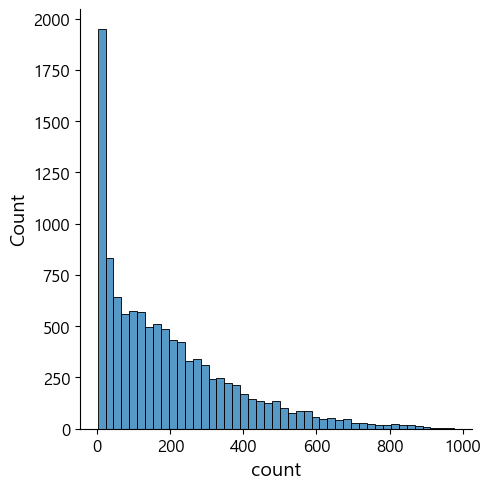

In [9]:
# 타겟 확인
# 타겟이 범주형인 경우는 확인을 해서 층화 추출, 오버 샘플링, 언더 샘플링 고려
# 타겟이 연속형인 경우는 정규 분포에 가까운지 확인해서, 한쪽으로 몰려있는 경우 로그 변환 고려

train['count'].describe()
sns.displot(train['count']) # 왼쪽으로 굉장히 쏠려있다

<Axes: xlabel='count', ylabel='Density'>

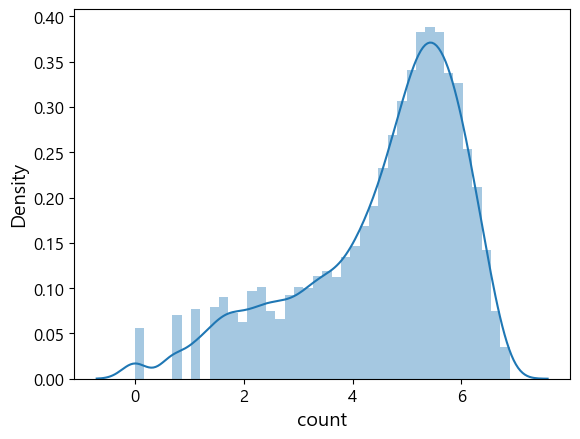

In [10]:
# 타겟을 로그 변환 후 시각화하기
sns.distplot(np.log(train['count']))

<Axes: xlabel='second', ylabel='count'>

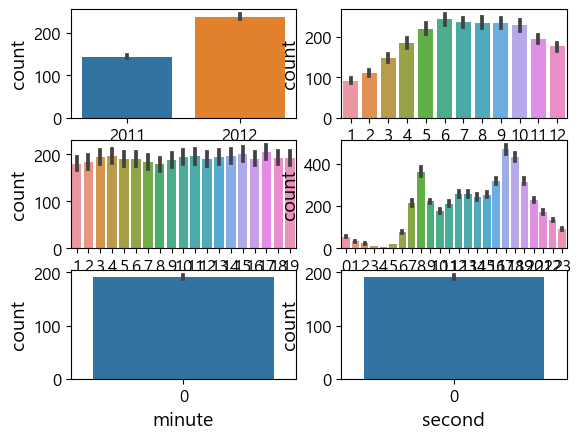

In [11]:
# 년월일 시분초에 따른 타겟의 변환
figure, axes = plt.subplots(nrows = 3, ncols = 2)

sns.barplot(x = 'year', y = 'count', data = train, ax = axes[0, 0])
sns.barplot(x = 'month', y = 'count', data = train, ax = axes[0, 1])
sns.barplot(x = 'day', y = 'count', data = train, ax = axes[1, 0])
sns.barplot(x = 'hour', y = 'count', data = train, ax = axes[1, 1])
sns.barplot(x = 'minute', y = 'count', data = train, ax = axes[2, 0])
sns.barplot(x = 'second', y = 'count', data = train, ax = axes[2, 1])

# 각 데이터가 유의미한 변화를 가져오면 훈련에 사용해야하고
# 변화가 없다면 사용안해도 됌
# day, minute, second 는 제거! 

<Axes: xlabel='workingday', ylabel='count'>

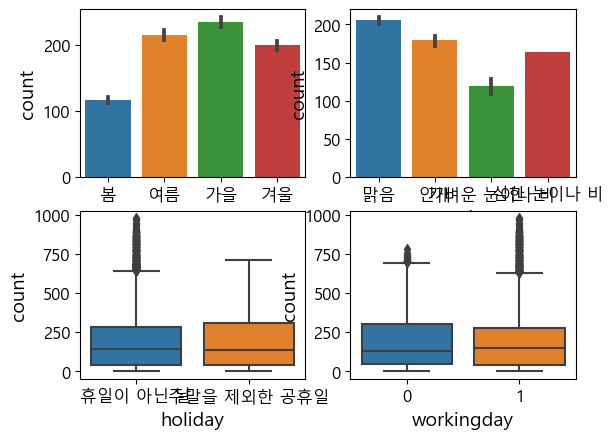

In [12]:
# 계절, 날씨, 공휴일 여부, 근무일 별 수량 변화

figure, axes = plt.subplots(nrows = 2, ncols = 2)

sns.barplot(x = 'season', y= 'count', data = train, ax = axes[0,0])
sns.barplot(x = 'weather', y= 'count', data = train, ax = axes[0,1])
sns.boxplot(x = 'holiday', y= 'count', data = train, ax = axes[1,0])
sns.boxplot(x = 'workingday', y= 'count', data = train, ax = axes[1,1])

# 검정색 작대기는 분산을 의미한다
# box plot을 이용하면 이상치의 분포 여부를 확인하는 게 가능

In [13]:
# 두가지 속성을 조합해서 분포를 알고자 하는 경우 : pointplot 이용
# 근무일, 공휴일, 요일, 계절, 날씨 에 따른 시간대 별 대여 수량을 확인
# 이건 왜 안되지..?
'''
figure, axes = plt.subplots(nrows = 5)

sns.pointplot(x = 'hour', y = 'count', hue = 'workingday', data = train, ax = axes[0])
sns.pointplot(x = 'hour', y = 'count', hue = 'holiday', data = train, ax = axes[1])
sns.pointplot(x = 'hour', y = 'count', hue = 'weekday', data = train, ax = axes[2])
sns.pointplot(x = 'hour', y = 'count', hue = 'season', data = train, ax = axes[3])
sns.pointplot(x = 'hour', y = 'count', hue = 'weather', data = train, ax = axes[4])
'''



"\nfigure, axes = plt.subplots(nrows = 5)\n\nsns.pointplot(x = 'hour', y = 'count', hue = 'workingday', data = train, ax = axes[0])\nsns.pointplot(x = 'hour', y = 'count', hue = 'holiday', data = train, ax = axes[1])\nsns.pointplot(x = 'hour', y = 'count', hue = 'weekday', data = train, ax = axes[2])\nsns.pointplot(x = 'hour', y = 'count', hue = 'season', data = train, ax = axes[3])\nsns.pointplot(x = 'hour', y = 'count', hue = 'weather', data = train, ax = axes[4])\n"

<Axes: xlabel='humidity', ylabel='count'>

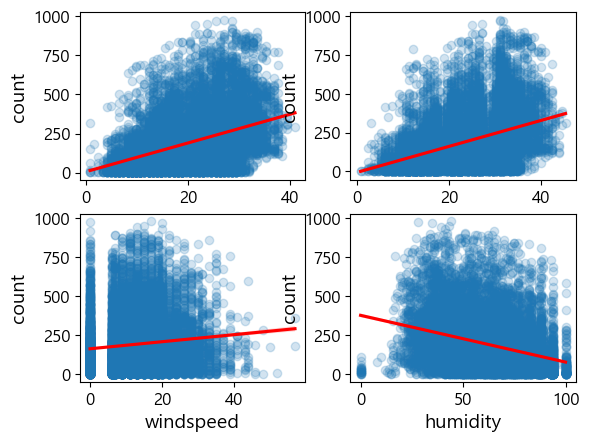

In [14]:
# 연속형 데이터는 피처와 상관관계를 파악할 필요가 있음 : 상관관계가 거의 없다면 제거해도 됨
# 상관관계 파악은 상관계수를 확인해도 되고 
# 산포도(regplot - reg는 선형식도 같이 출력)를 이용하기도 하면 
# 상관계수를 구한 후 heatmap 같은 도구를 이용해서 시각화 하기도 합니다.

# train.info()
figure, axes = plt.subplots(nrows = 2, ncols = 2)

sns.regplot(x = 'temp', y = 'count', scatter_kws = {'alpha' : 0.2},
            line_kws = {'color' : 'red'}, data = train, ax = axes[0,0])
sns.regplot(x = 'atemp', y = 'count', scatter_kws = {'alpha' : 0.2},
            line_kws = {'color' : 'red'}, data = train, ax = axes[0,1])
sns.regplot(x = 'windspeed', y = 'count', scatter_kws = {'alpha' : 0.2},
            line_kws = {'color' : 'red'}, data = train, ax = axes[1,0])
sns.regplot(x = 'humidity', y = 'count', scatter_kws = {'alpha' : 0.2},
            line_kws = {'color' : 'red'}, data = train, ax = axes[1,1])

## 규제가 없는 선형회귀 분석하기

### 데이터 전처리

In [15]:
train = pd.read_csv('data_ML/bike/train.csv')
test = pd.read_csv('data_ML/bike/test.csv')
submission = pd.read_csv('data_ML/bike/sampleSubmission.csv')

In [16]:
# 이상치 제거
# 이상치
# 범주형에서 기본값 이외의 데이터나 수치형 데이터에서 범주에 맞지 않는 데이터나 극단치
# 도메인에 따라 정상적인 입력이지만 이상치로 판단

# 심한 눈이나 비가 내리는데 자전거를 대여하는 것은 이상한 상황 - 제거
train = train[train['weather']!= 4]

In [17]:
# train 데이터와 test 데이터를 합치기 - 동일한 구조 만들기
# train 에만 있고 test에는 없는 컬럼이 있기 때문에
# 경진대회에서는 train 과 test 를 분리해서 제공하는데 
# 두개의 구조가 다르고, test 는 target이 없음
# 그걸로 지원자들 모델을 점수 매기기 때문에

# 별도의 인덱스를 설정하지 않으면 인덱스는 0부터 시작하는 일련 번호
# 인덱스를 설정하지 않은 상태로 만든 DataFrame 을 행 방향으로 결합하면
# 인덱스가 중첩될 수 있습니다.
# 기각!
'''
all_data_temp = pd.concat([train, test])
all_data_temp
'''
# 기존의 인덱스는 무시하고 결합 해야함
all_data = pd.concat([train, test], ignore_index = True)
all_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17373,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.001,NaN,NaN,NaN
17374,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.001,NaN,NaN,NaN
17375,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.001,NaN,NaN,NaN
17376,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.998,NaN,NaN,NaN


In [19]:
# 파생 피처 생성 - datetime을 이용해서 새로운 열(년 월 일 시 분 초 요일)을 생성
# 분, 초 는 필요가 없었음!
# 년월일, 년, 시, 요일 이렇게 4개의 컬럼으로 만들어보려고 함!
all_data['datetime']

0        2011-01-01 00:00:00
1        2011-01-01 01:00:00
2        2011-01-01 02:00:00
3        2011-01-01 03:00:00
4        2011-01-01 04:00:00
                ...         
17373    2012-12-31 19:00:00
17374    2012-12-31 20:00:00
17375    2012-12-31 21:00:00
17376    2012-12-31 22:00:00
17377    2012-12-31 23:00:00
Name: datetime, Length: 17378, dtype: object

In [20]:
from datetime import datetime

# datatime 필드에서 앞의 날짜 부분만 잘라서 data 필드 생성
all_data['date'] = all_data['datetime'].apply(lambda x : x.split()[0])
# datatime 필드에서 앞의 년도 부분만 잘라서 year 필드 생성
all_data['year'] = all_data['datetime'].apply(lambda x : x.split()[0].split('-')[0])
# datatime 필드에서 앞의 시간 부분만 잘라서 hour 필드 생성
all_data['hour'] = all_data['datetime'].apply(lambda x : x.split()[1].split(':')[0])
# datatime 필드에서 요일을 가지고 weekday 필드 생성
all_data['weekday'] = all_data['date'].apply(
    lambda x : datetime.strptime(x, "%Y-%m-%d").weekday())

all_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,hour,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0,2011-01-01,2011,00,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0,2011-01-01,2011,01,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0,2011-01-01,2011,02,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0,2011-01-01,2011,03,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0,2011-01-01,2011,04,5


In [21]:
# 불필요한 피쳐 제거
# casual, registered, datetime, date, windspeed

# all_data = all_data.drop(['casual', 'registered', 'datetime', 'date', 'windspeed'],axis = 1)
# 이러면 내가 나중에 어떤 컬럼을 지웠는지 알 수 없어서 
# 이렇게 하면 변수처럼 활용도 가능하고
# 몬가 멋있어 보인다!!

drop_features = ['casual', 'registered', 'datetime', 'date', 'windspeed']
all_data = all_data.drop(drop_features, axis = 1)

In [22]:
all_data

,season,holiday,workingday,weather,temp,atemp,humidity,count,year,hour,weekday
0,1,0,0,1,9.84,14.395,81,16.0,2011,00,5
1,1,0,0,1,9.02,13.635,80,40.0,2011,01,5
2,1,0,0,1,9.02,13.635,80,32.0,2011,02,5
3,1,0,0,1,9.84,14.395,75,13.0,2011,03,5
4,1,0,0,1,9.84,14.395,75,1.0,2011,04,5
...,...,...,...,...,...,...,...,...,...,...,...
17373,1,0,1,2,10.66,12.880,60,NaN,2012,19,0
17374,1,0,1,2,10.66,12.880,60,NaN,2012,20,0
17375,1,0,1,1,10.66,12.880,60,NaN,2012,21,0
17376,1,0,1,1,10.66,13.635,56,NaN,2012,22,0


### 모델 생성 및 전처리

In [23]:
# 훈련, 테스트 데이터 분리
X_train = all_data[~pd.isnull(all_data['count'])]
X_test = all_data[pd.isnull(all_data['count'])]

# 피쳐와 타겟 분리
X_train = X_train.drop(['count'],axis = 1)
X_test = X_test.drop(['count'],axis = 1)

# row데이터에서 타겟으로 가져오기
y = train['count']

X_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,year,hour,weekday
0,1,0,0,1,9.84,14.395,81,2011,00,5
1,1,0,0,1,9.02,13.635,80,2011,01,5
2,1,0,0,1,9.02,13.635,80,2011,02,5
3,1,0,0,1,9.84,14.395,75,2011,03,5
4,1,0,0,1,9.84,14.395,75,2011,04,5


In [34]:
# 평가 지표 함수 - RMSLE
# 타겟이 치우쳐 있어서 로그 변환을 수행하는 것이 좋은 모델을 만들 수 있습니다.

# y_true는 실제 값이고, y_pred 는 예측한 값이고 convertExp 는 로그 변환 여부
def rmsle(y_true, y_pred, convertExp = True) :
    # 로그 변환을 한 경우에는 원래 값으로 복원
    if convertExp :
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
    # 로그 변환을 할때 1을 더해주지 않으면 0이 될 수 있고 0인 경우 에러가 발생
    # 로그 변환을 할때는 1을 더해서 이를 방지해야 합니다.
    log_true = np.nan_to_num(np.log(y_true + 1))
    log_pred = np.nan_to_num(np.log(y_pred + 1))    
    
    #RMSLE 계산
    output = np.sqrt(np.mean((log_true - log_pred)**2))
    return  output

In [35]:
# 모델 생성 및 훈련
from sklearn.linear_model import LinearRegression

linear_reg_model = LinearRegression()

# 타겟의 로그 변환
log_y = np.log(y)

# 훈련
linear_reg_model.fit(X_train, log_y)

# 예측
preds = linear_reg_model.predict(X_train)

print('일반 선형 회귀의 RMSLE : ', rmsle(log_y, preds, True))


일반 선형 회귀의 RMSLE :  1.0204980189305026


### 답안 생성

In [36]:
linearreg_preds = linear_reg_model.predict(X_test)

#원래 데이터로 복원
submission['count'] = np.exp(linearreg_preds)
submission.to_csv('submission.csv',index = False)

## 규제가 있는 선형회귀 분석하기

### Ridge(가중치 감소), Lasso(제거 가능), ElasticNet 
### : alpha 라는 규제 강도 존재

In [37]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# 기본 모델
ridge_model = Ridge()
lasso_model = Lasso()
elastic_model = ElasticNet()

# 파라미터 생성
ridge_params = {
    'max_iter': [3000],
    'alpha' : [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]
}

# 사용자 정의 함수를 평가지표로 사용
# 우리가 만든 rmsle 함수 사용하고 적은 점수가 좋다고 설정
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better = False)
gridsearch_ridge_model = GridSearchCV(estimator = ridge_model,
                                     param_grid = ridge_params,
                                     scoring = rmsle_scorer,
                                     cv =5)
log_y = np.log(y)
gridsearch_ridge_model.fit(X_train, log_y)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400,
                                   800, 900, 1000],
                         'max_iter': [3000]},
             scoring=make_scorer(rmsle, greater_is_better=False))

In [38]:
# 최적의 모델로 예측
preds = gridsearch_ridge_model.best_estimator_.predict(X_train)
print('릿지 적용한 RMSLE : ', rmsle(log_y, preds, True))

# 이 데이터는 비선형으로 예측됨
# 즉 Lasso, ElasticNet도 효과가 없을 듯


릿지 적용한 RMSLE :  1.020497980747181


## 부스팅 모델 적용
#### RandomForest, GradientBoostin, AdaBoosting, HistGradientBoosting - sklearn 제공
#### XGBM, LightGBM, CatBoost - 별도 라이브러리 적용

In [44]:
# !pip install xgboost
# !pip install catboost
# !pip install lightgbm

In [48]:
# 부스팅 모델 생성

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

rf_reg = RandomForestRegressor()
gbm_reg = GradientBoostingRegressor(n_estimators = 500)
hgbm_reg = HistGradientBoostingRegressor(max_iter = 500)

xgb_reg = XGBRegressor(n_estimators = 500)
lgbm_reg = LGBMRegressor(n_estimators = 500)
cat_reg = CatBoostRegressor(iterations = 500)

In [49]:
# 파라미터 값 생성
params = {
    'random_state' : [42],
    'n_estimators' : [100, 300, 500, 700]
}

hgbm_params = {
    'random_state' : [42],
    'max_iter' : [100, 300, 500, 700]
}

catgbm_params = {
    'random_state' : [42],
    'iterations' : [100, 300, 500, 700]
}


In [ ]:
# 타겟값 생성
log_y = np.log(y)

In [53]:
# 랜덤 포레스트 적용
gridsearch_random_forest_model = GridSearchCV(estimator = rf_reg,
                                             param_grid = params,
                                             scoring = rmsle_scorer,
                                             cv = 5)
gridsearch_random_forest_model.fit(X_train, log_y)
preds = gridsearch_random_forest_model.best_estimator_.predict(X_train)
print('랜덤 포레스트의 RMSLE 값 : ', rmsle(log_y, preds, True))

랜덤 포레스트의 RMSLE 값 :  0.11124607292494956


In [55]:
# gradient 부스팅 적용
gridsearch_gbm_model = GridSearchCV(estimator = gbm_reg,
                                             param_grid = params,
                                             scoring = rmsle_scorer,
                                             cv = 5)
gridsearch_gbm_model.fit(X_train, log_y)
preds = gridsearch_gbm_model.best_estimator_.predict(X_train)
print('GBM의 RMSLE 값 : ', rmsle(log_y, preds, True))

GBM의 RMSLE 값 :  0.27007893677151384


In [58]:
# HistGradient 부스팅 적용
gridsearch_hgbm_model = GridSearchCV(estimator = hgbm_reg,
                                             param_grid = hgbm_params,
                                             scoring = rmsle_scorer,
                                             cv = 5)
gridsearch_hgbm_model.fit(X_train.values, log_y.values)
preds = gridsearch_hgbm_model.best_estimator_.predict(X_train.values)
print('HGBM의 RMSLE 값 : ', rmsle(log_y, preds, True))

HGBM의 RMSLE 값 :  0.23245216702971983


In [59]:
# XGB 적용
gridsearch_xgb_model = GridSearchCV(estimator = xgb_reg,
                                   param_grid = params,
                                   scoring = rmsle_scorer,
                                   cv = 5)
# XGB 는 DataFrame 을 데이터로 사용하는 것이 안됩니다.
# numpy 의 ndarray만 가능
gridsearch_xgb_model.fit(X_train.values, log_y.values)
preds = gridsearch_xgb_model.best_estimator_.predict(X_train.values)

print('XGB RMSLE 값 : ', rmsle(log_y, preds, True))

XGB RMSLE 값 :  0.19626309218676358


In [57]:
# Light GMB부스팅 적용
gridsearch_lgbm_model = GridSearchCV(estimator = lgbm_reg,
                                             param_grid = params,
                                             scoring = rmsle_scorer,
                                             cv = 5)
gridsearch_lgbm_model.fit(X_train.values, log_y.values)
preds = gridsearch_lgbm_model.best_estimator_.predict(X_train.values)
print('LGBM의 RMSLE 값 : ', rmsle(log_y, preds, True))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 234
[LightGBM] [Info] Number of data points in the train set: 8708, number of used features: 10
[LightGBM] [Info] Start training from score 4.721909
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 8708, number of used features: 10
[LightGBM] [Info] Start training from score 4.527066
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

In [62]:
# CatBoost 적용
gridsearch_catgbm_model = GridSearchCV(estimator = cat_reg,
                                             param_grid = catgbm_params,
                                             scoring = rmsle_scorer,
                                             cv = 5)
gridsearch_catgbm_model.fit(X_train.values, log_y.values)
preds = gridsearch_catgbm_model.best_estimator_.predict(X_train.values)
print('CatBGM의 RMSLE 값 : ', rmsle(log_y, preds, True))

Learning rate set to 0.374703
0:	learn: 1.0595747	total: 146ms	remaining: 14.4s
1:	learn: 0.8177145	total: 148ms	remaining: 7.23s
2:	learn: 0.6881639	total: 149ms	remaining: 4.82s
3:	learn: 0.5890287	total: 151ms	remaining: 3.62s
4:	learn: 0.5408887	total: 155ms	remaining: 2.95s
5:	learn: 0.5058980	total: 161ms	remaining: 2.52s
6:	learn: 0.4839521	total: 164ms	remaining: 2.18s
7:	learn: 0.4293622	total: 168ms	remaining: 1.94s
8:	learn: 0.4085822	total: 172ms	remaining: 1.73s
9:	learn: 0.3979271	total: 175ms	remaining: 1.58s
10:	learn: 0.3714284	total: 179ms	remaining: 1.45s
11:	learn: 0.3596647	total: 183ms	remaining: 1.34s
12:	learn: 0.3540500	total: 185ms	remaining: 1.24s
13:	learn: 0.3498275	total: 187ms	remaining: 1.15s
14:	learn: 0.3419997	total: 190ms	remaining: 1.07s
15:	learn: 0.3362728	total: 191ms	remaining: 1s
16:	learn: 0.3290755	total: 193ms	remaining: 945ms
17:	learn: 0.3271883	total: 196ms	remaining: 891ms
18:	learn: 0.3249492	total: 198ms	remaining: 843ms
19:	learn: 0.3

36:	learn: 0.3115453	total: 47.9ms	remaining: 81.6ms
37:	learn: 0.3100971	total: 49.4ms	remaining: 80.6ms
38:	learn: 0.3083172	total: 51.1ms	remaining: 80ms
39:	learn: 0.3070693	total: 52.6ms	remaining: 78.9ms
40:	learn: 0.3058239	total: 54.3ms	remaining: 78.1ms
41:	learn: 0.3037581	total: 55.9ms	remaining: 77.2ms
42:	learn: 0.3026684	total: 57.6ms	remaining: 76.3ms
43:	learn: 0.3020422	total: 59.1ms	remaining: 75.2ms
44:	learn: 0.3013049	total: 60.5ms	remaining: 74ms
45:	learn: 0.3002765	total: 62ms	remaining: 72.7ms
46:	learn: 0.2989446	total: 63.2ms	remaining: 71.3ms
47:	learn: 0.2971266	total: 64.6ms	remaining: 69.9ms
48:	learn: 0.2959856	total: 65.9ms	remaining: 68.6ms
49:	learn: 0.2946629	total: 67.2ms	remaining: 67.2ms
50:	learn: 0.2935542	total: 68.6ms	remaining: 65.9ms
51:	learn: 0.2925571	total: 69.8ms	remaining: 64.5ms
52:	learn: 0.2915351	total: 71.2ms	remaining: 63.1ms
53:	learn: 0.2913117	total: 72.5ms	remaining: 61.8ms
54:	learn: 0.2905918	total: 73.8ms	remaining: 60.4ms

51:	learn: 0.3064031	total: 90.9ms	remaining: 83.9ms
52:	learn: 0.3058828	total: 94.6ms	remaining: 83.9ms
53:	learn: 0.3048943	total: 97.2ms	remaining: 82.8ms
54:	learn: 0.3045265	total: 101ms	remaining: 82.3ms
55:	learn: 0.3041677	total: 103ms	remaining: 81.2ms
56:	learn: 0.3036189	total: 106ms	remaining: 80.3ms
57:	learn: 0.3030131	total: 110ms	remaining: 79.6ms
58:	learn: 0.3023818	total: 113ms	remaining: 78.7ms
59:	learn: 0.3018467	total: 117ms	remaining: 78ms
60:	learn: 0.3006090	total: 121ms	remaining: 77.3ms
61:	learn: 0.2998872	total: 124ms	remaining: 76.1ms
62:	learn: 0.2990277	total: 126ms	remaining: 74.3ms
63:	learn: 0.2983955	total: 129ms	remaining: 72.3ms
64:	learn: 0.2977432	total: 131ms	remaining: 70.4ms
65:	learn: 0.2974620	total: 133ms	remaining: 68.4ms
66:	learn: 0.2969913	total: 135ms	remaining: 66.5ms
67:	learn: 0.2966495	total: 137ms	remaining: 64.4ms
68:	learn: 0.2958952	total: 139ms	remaining: 62.3ms
69:	learn: 0.2945111	total: 140ms	remaining: 60.1ms
70:	learn: 

165:	learn: 0.2607372	total: 261ms	remaining: 210ms
166:	learn: 0.2605230	total: 263ms	remaining: 209ms
167:	learn: 0.2602791	total: 265ms	remaining: 208ms
168:	learn: 0.2600872	total: 267ms	remaining: 207ms
169:	learn: 0.2597811	total: 268ms	remaining: 205ms
170:	learn: 0.2595825	total: 270ms	remaining: 204ms
171:	learn: 0.2594548	total: 272ms	remaining: 202ms
172:	learn: 0.2591765	total: 273ms	remaining: 201ms
173:	learn: 0.2589553	total: 275ms	remaining: 199ms
174:	learn: 0.2587408	total: 276ms	remaining: 197ms
175:	learn: 0.2583647	total: 278ms	remaining: 196ms
176:	learn: 0.2581639	total: 280ms	remaining: 195ms
177:	learn: 0.2580172	total: 282ms	remaining: 193ms
178:	learn: 0.2578024	total: 284ms	remaining: 192ms
179:	learn: 0.2575349	total: 286ms	remaining: 191ms
180:	learn: 0.2573033	total: 288ms	remaining: 189ms
181:	learn: 0.2569915	total: 289ms	remaining: 187ms
182:	learn: 0.2566964	total: 290ms	remaining: 186ms
183:	learn: 0.2565351	total: 292ms	remaining: 184ms
184:	learn: 

79:	learn: 0.3237448	total: 107ms	remaining: 296ms
80:	learn: 0.3233330	total: 109ms	remaining: 295ms
81:	learn: 0.3229755	total: 111ms	remaining: 294ms
82:	learn: 0.3225475	total: 112ms	remaining: 293ms
83:	learn: 0.3219110	total: 113ms	remaining: 291ms
84:	learn: 0.3216170	total: 115ms	remaining: 290ms
85:	learn: 0.3211588	total: 116ms	remaining: 290ms
86:	learn: 0.3206355	total: 118ms	remaining: 289ms
87:	learn: 0.3202823	total: 119ms	remaining: 287ms
88:	learn: 0.3195231	total: 120ms	remaining: 286ms
89:	learn: 0.3192286	total: 122ms	remaining: 284ms
90:	learn: 0.3182830	total: 123ms	remaining: 282ms
91:	learn: 0.3177792	total: 124ms	remaining: 281ms
92:	learn: 0.3173541	total: 125ms	remaining: 279ms
93:	learn: 0.3167358	total: 127ms	remaining: 278ms
94:	learn: 0.3163714	total: 128ms	remaining: 276ms
95:	learn: 0.3159814	total: 129ms	remaining: 275ms
96:	learn: 0.3154890	total: 131ms	remaining: 273ms
97:	learn: 0.3148802	total: 132ms	remaining: 272ms
98:	learn: 0.3147032	total: 133

3:	learn: 0.9751989	total: 6.22ms	remaining: 460ms
4:	learn: 0.8907449	total: 7.97ms	remaining: 470ms
5:	learn: 0.8225725	total: 9.23ms	remaining: 452ms
6:	learn: 0.7687219	total: 10.8ms	remaining: 454ms
7:	learn: 0.7258560	total: 12.2ms	remaining: 445ms
8:	learn: 0.6768566	total: 13.9ms	remaining: 450ms
9:	learn: 0.6312408	total: 15.2ms	remaining: 440ms
10:	learn: 0.6037704	total: 16.9ms	remaining: 443ms
11:	learn: 0.5813896	total: 18.6ms	remaining: 446ms
12:	learn: 0.5542558	total: 19.8ms	remaining: 437ms
13:	learn: 0.5381104	total: 21.3ms	remaining: 436ms
14:	learn: 0.5178123	total: 22.8ms	remaining: 434ms
15:	learn: 0.4960840	total: 24.6ms	remaining: 437ms
16:	learn: 0.4805329	total: 26.2ms	remaining: 436ms
17:	learn: 0.4649739	total: 27.8ms	remaining: 436ms
18:	learn: 0.4521193	total: 29.7ms	remaining: 440ms
19:	learn: 0.4418830	total: 31.5ms	remaining: 441ms
20:	learn: 0.4342106	total: 32.7ms	remaining: 435ms
21:	learn: 0.4290029	total: 34ms	remaining: 429ms
22:	learn: 0.4241791	

223:	learn: 0.2648210	total: 389ms	remaining: 132ms
224:	learn: 0.2645782	total: 391ms	remaining: 130ms
225:	learn: 0.2644356	total: 392ms	remaining: 128ms
226:	learn: 0.2640792	total: 394ms	remaining: 127ms
227:	learn: 0.2639233	total: 396ms	remaining: 125ms
228:	learn: 0.2636932	total: 397ms	remaining: 123ms
229:	learn: 0.2632246	total: 399ms	remaining: 121ms
230:	learn: 0.2631819	total: 400ms	remaining: 120ms
231:	learn: 0.2629459	total: 402ms	remaining: 118ms
232:	learn: 0.2627957	total: 404ms	remaining: 116ms
233:	learn: 0.2626544	total: 405ms	remaining: 114ms
234:	learn: 0.2623693	total: 407ms	remaining: 113ms
235:	learn: 0.2622078	total: 409ms	remaining: 111ms
236:	learn: 0.2619577	total: 411ms	remaining: 109ms
237:	learn: 0.2618243	total: 412ms	remaining: 107ms
238:	learn: 0.2615773	total: 415ms	remaining: 106ms
239:	learn: 0.2612721	total: 417ms	remaining: 104ms
240:	learn: 0.2609575	total: 420ms	remaining: 103ms
241:	learn: 0.2607252	total: 422ms	remaining: 101ms
242:	learn: 

121:	learn: 0.3049690	total: 191ms	remaining: 278ms
122:	learn: 0.3046747	total: 193ms	remaining: 277ms
123:	learn: 0.3046567	total: 194ms	remaining: 275ms
124:	learn: 0.3041109	total: 196ms	remaining: 274ms
125:	learn: 0.3039159	total: 197ms	remaining: 272ms
126:	learn: 0.3034002	total: 198ms	remaining: 270ms
127:	learn: 0.3033811	total: 199ms	remaining: 268ms
128:	learn: 0.3033663	total: 201ms	remaining: 266ms
129:	learn: 0.3026834	total: 202ms	remaining: 264ms
130:	learn: 0.3023185	total: 203ms	remaining: 262ms
131:	learn: 0.3017890	total: 205ms	remaining: 261ms
132:	learn: 0.3013630	total: 207ms	remaining: 259ms
133:	learn: 0.3010967	total: 208ms	remaining: 258ms
134:	learn: 0.3009011	total: 210ms	remaining: 256ms
135:	learn: 0.3006493	total: 212ms	remaining: 256ms
136:	learn: 0.3005126	total: 214ms	remaining: 254ms
137:	learn: 0.3002318	total: 216ms	remaining: 253ms
138:	learn: 0.2998631	total: 217ms	remaining: 252ms
139:	learn: 0.2994995	total: 219ms	remaining: 250ms
140:	learn: 

15:	learn: 0.5257400	total: 37.3ms	remaining: 662ms
16:	learn: 0.5111683	total: 40.4ms	remaining: 672ms
17:	learn: 0.5022728	total: 42.9ms	remaining: 672ms
18:	learn: 0.4827213	total: 45.6ms	remaining: 675ms
19:	learn: 0.4749757	total: 48.2ms	remaining: 675ms
20:	learn: 0.4670400	total: 50.8ms	remaining: 675ms
21:	learn: 0.4609734	total: 53.9ms	remaining: 681ms
22:	learn: 0.4528060	total: 56.7ms	remaining: 683ms
23:	learn: 0.4413915	total: 59.8ms	remaining: 687ms
24:	learn: 0.4362366	total: 63.1ms	remaining: 694ms
25:	learn: 0.4293895	total: 66.1ms	remaining: 697ms
26:	learn: 0.4237111	total: 69.3ms	remaining: 701ms
27:	learn: 0.4141360	total: 71.7ms	remaining: 696ms
28:	learn: 0.4106964	total: 73.4ms	remaining: 686ms
29:	learn: 0.4058342	total: 75.3ms	remaining: 677ms
30:	learn: 0.4026402	total: 77ms	remaining: 668ms
31:	learn: 0.4005468	total: 78.9ms	remaining: 660ms
32:	learn: 0.3945136	total: 80.8ms	remaining: 654ms
33:	learn: 0.3919549	total: 82.3ms	remaining: 644ms
34:	learn: 0.3

242:	learn: 0.2759018	total: 431ms	remaining: 101ms
243:	learn: 0.2757766	total: 433ms	remaining: 99.4ms
244:	learn: 0.2754206	total: 434ms	remaining: 97.5ms
245:	learn: 0.2752105	total: 436ms	remaining: 95.7ms
246:	learn: 0.2750233	total: 437ms	remaining: 93.8ms
247:	learn: 0.2748711	total: 439ms	remaining: 92ms
248:	learn: 0.2746176	total: 440ms	remaining: 90.1ms
249:	learn: 0.2742784	total: 441ms	remaining: 88.3ms
250:	learn: 0.2736841	total: 443ms	remaining: 86.5ms
251:	learn: 0.2734479	total: 444ms	remaining: 84.6ms
252:	learn: 0.2732689	total: 446ms	remaining: 82.8ms
253:	learn: 0.2729344	total: 447ms	remaining: 81ms
254:	learn: 0.2727181	total: 449ms	remaining: 79.3ms
255:	learn: 0.2726336	total: 451ms	remaining: 77.6ms
256:	learn: 0.2723682	total: 455ms	remaining: 76.1ms
257:	learn: 0.2722989	total: 458ms	remaining: 74.6ms
258:	learn: 0.2720192	total: 462ms	remaining: 73.1ms
259:	learn: 0.2718147	total: 465ms	remaining: 71.6ms
260:	learn: 0.2717514	total: 468ms	remaining: 69.9m

129:	learn: 0.2875220	total: 211ms	remaining: 601ms
130:	learn: 0.2872394	total: 213ms	remaining: 601ms
131:	learn: 0.2869986	total: 215ms	remaining: 600ms
132:	learn: 0.2868362	total: 217ms	remaining: 598ms
133:	learn: 0.2863140	total: 218ms	remaining: 596ms
134:	learn: 0.2860291	total: 220ms	remaining: 594ms
135:	learn: 0.2855734	total: 221ms	remaining: 592ms
136:	learn: 0.2854077	total: 223ms	remaining: 590ms
137:	learn: 0.2850855	total: 224ms	remaining: 588ms
138:	learn: 0.2842380	total: 226ms	remaining: 587ms
139:	learn: 0.2837318	total: 228ms	remaining: 586ms
140:	learn: 0.2833912	total: 230ms	remaining: 586ms
141:	learn: 0.2830143	total: 233ms	remaining: 587ms
142:	learn: 0.2827957	total: 235ms	remaining: 586ms
143:	learn: 0.2825716	total: 237ms	remaining: 586ms
144:	learn: 0.2822619	total: 239ms	remaining: 585ms
145:	learn: 0.2818839	total: 241ms	remaining: 586ms
146:	learn: 0.2815477	total: 244ms	remaining: 586ms
147:	learn: 0.2813204	total: 246ms	remaining: 586ms
148:	learn: 

354:	learn: 0.2454341	total: 620ms	remaining: 253ms
355:	learn: 0.2452655	total: 622ms	remaining: 251ms
356:	learn: 0.2451643	total: 623ms	remaining: 249ms
357:	learn: 0.2450455	total: 624ms	remaining: 248ms
358:	learn: 0.2450019	total: 625ms	remaining: 246ms
359:	learn: 0.2449352	total: 627ms	remaining: 244ms
360:	learn: 0.2448182	total: 628ms	remaining: 242ms
361:	learn: 0.2446662	total: 629ms	remaining: 240ms
362:	learn: 0.2446247	total: 631ms	remaining: 238ms
363:	learn: 0.2444646	total: 633ms	remaining: 236ms
364:	learn: 0.2443580	total: 634ms	remaining: 235ms
365:	learn: 0.2442740	total: 636ms	remaining: 233ms
366:	learn: 0.2441357	total: 639ms	remaining: 232ms
367:	learn: 0.2440365	total: 643ms	remaining: 231ms
368:	learn: 0.2438920	total: 646ms	remaining: 230ms
369:	learn: 0.2436726	total: 650ms	remaining: 228ms
370:	learn: 0.2434909	total: 653ms	remaining: 227ms
371:	learn: 0.2433582	total: 657ms	remaining: 226ms
372:	learn: 0.2432207	total: 660ms	remaining: 225ms
373:	learn: 

121:	learn: 0.3246119	total: 213ms	remaining: 660ms
122:	learn: 0.3242436	total: 216ms	remaining: 662ms
123:	learn: 0.3238628	total: 218ms	remaining: 662ms
124:	learn: 0.3234765	total: 220ms	remaining: 661ms
125:	learn: 0.3231519	total: 223ms	remaining: 661ms
126:	learn: 0.3229314	total: 225ms	remaining: 662ms
127:	learn: 0.3225385	total: 227ms	remaining: 660ms
128:	learn: 0.3222893	total: 229ms	remaining: 659ms
129:	learn: 0.3218418	total: 231ms	remaining: 657ms
130:	learn: 0.3215329	total: 233ms	remaining: 656ms
131:	learn: 0.3213318	total: 235ms	remaining: 655ms
132:	learn: 0.3211103	total: 237ms	remaining: 653ms
133:	learn: 0.3208648	total: 238ms	remaining: 650ms
134:	learn: 0.3205805	total: 239ms	remaining: 647ms
135:	learn: 0.3203643	total: 241ms	remaining: 644ms
136:	learn: 0.3199211	total: 242ms	remaining: 642ms
137:	learn: 0.3195735	total: 244ms	remaining: 640ms
138:	learn: 0.3191398	total: 246ms	remaining: 640ms
139:	learn: 0.3187876	total: 248ms	remaining: 639ms
140:	learn: 

318:	learn: 0.2808498	total: 606ms	remaining: 344ms
319:	learn: 0.2807751	total: 608ms	remaining: 342ms
320:	learn: 0.2804780	total: 609ms	remaining: 340ms
321:	learn: 0.2803932	total: 610ms	remaining: 337ms
322:	learn: 0.2802604	total: 612ms	remaining: 335ms
323:	learn: 0.2801595	total: 613ms	remaining: 333ms
324:	learn: 0.2800426	total: 615ms	remaining: 331ms
325:	learn: 0.2798231	total: 616ms	remaining: 329ms
326:	learn: 0.2796119	total: 617ms	remaining: 327ms
327:	learn: 0.2794124	total: 619ms	remaining: 325ms
328:	learn: 0.2791547	total: 620ms	remaining: 322ms
329:	learn: 0.2789633	total: 622ms	remaining: 320ms
330:	learn: 0.2788823	total: 623ms	remaining: 318ms
331:	learn: 0.2785864	total: 625ms	remaining: 316ms
332:	learn: 0.2783706	total: 626ms	remaining: 314ms
333:	learn: 0.2782638	total: 629ms	remaining: 312ms
334:	learn: 0.2781013	total: 631ms	remaining: 311ms
335:	learn: 0.2779776	total: 633ms	remaining: 309ms
336:	learn: 0.2777284	total: 635ms	remaining: 307ms
337:	learn: 

18:	learn: 0.5717384	total: 30.3ms	remaining: 766ms
19:	learn: 0.5577645	total: 32.3ms	remaining: 775ms
20:	learn: 0.5462821	total: 33.9ms	remaining: 774ms
21:	learn: 0.5328129	total: 36ms	remaining: 782ms
22:	learn: 0.5188379	total: 39.1ms	remaining: 812ms
23:	learn: 0.5075736	total: 42.4ms	remaining: 840ms
24:	learn: 0.5002220	total: 45.3ms	remaining: 861ms
25:	learn: 0.4853171	total: 48.3ms	remaining: 881ms
26:	learn: 0.4776836	total: 51.5ms	remaining: 902ms
27:	learn: 0.4652566	total: 54.4ms	remaining: 917ms
28:	learn: 0.4609427	total: 57.6ms	remaining: 935ms
29:	learn: 0.4536820	total: 61.1ms	remaining: 957ms
30:	learn: 0.4487426	total: 64.9ms	remaining: 982ms
31:	learn: 0.4437843	total: 68.3ms	remaining: 999ms
32:	learn: 0.4386533	total: 71.2ms	remaining: 1.01s
33:	learn: 0.4339886	total: 73.9ms	remaining: 1.01s
34:	learn: 0.4277650	total: 77.3ms	remaining: 1.03s
35:	learn: 0.4235729	total: 80.5ms	remaining: 1.04s
36:	learn: 0.4207315	total: 84ms	remaining: 1.05s
37:	learn: 0.418

231:	learn: 0.2828169	total: 425ms	remaining: 491ms
232:	learn: 0.2826829	total: 427ms	remaining: 489ms
233:	learn: 0.2822236	total: 428ms	remaining: 487ms
234:	learn: 0.2819514	total: 430ms	remaining: 485ms
235:	learn: 0.2817659	total: 431ms	remaining: 482ms
236:	learn: 0.2814212	total: 433ms	remaining: 480ms
237:	learn: 0.2811779	total: 434ms	remaining: 478ms
238:	learn: 0.2811117	total: 435ms	remaining: 475ms
239:	learn: 0.2809710	total: 437ms	remaining: 473ms
240:	learn: 0.2807288	total: 438ms	remaining: 471ms
241:	learn: 0.2806203	total: 440ms	remaining: 469ms
242:	learn: 0.2805538	total: 441ms	remaining: 466ms
243:	learn: 0.2802649	total: 443ms	remaining: 464ms
244:	learn: 0.2799884	total: 444ms	remaining: 462ms
245:	learn: 0.2797908	total: 447ms	remaining: 461ms
246:	learn: 0.2795526	total: 449ms	remaining: 460ms
247:	learn: 0.2793308	total: 452ms	remaining: 459ms
248:	learn: 0.2791009	total: 454ms	remaining: 458ms
249:	learn: 0.2788892	total: 457ms	remaining: 457ms
250:	learn: 

438:	learn: 0.2532518	total: 812ms	remaining: 113ms
439:	learn: 0.2531644	total: 814ms	remaining: 111ms
440:	learn: 0.2529675	total: 816ms	remaining: 109ms
441:	learn: 0.2528351	total: 818ms	remaining: 107ms
442:	learn: 0.2527558	total: 820ms	remaining: 105ms
443:	learn: 0.2526686	total: 821ms	remaining: 104ms
444:	learn: 0.2525346	total: 822ms	remaining: 102ms
445:	learn: 0.2523370	total: 824ms	remaining: 99.7ms
446:	learn: 0.2522576	total: 825ms	remaining: 97.8ms
447:	learn: 0.2521946	total: 827ms	remaining: 95.9ms
448:	learn: 0.2521028	total: 828ms	remaining: 94ms
449:	learn: 0.2520243	total: 829ms	remaining: 92.2ms
450:	learn: 0.2520097	total: 831ms	remaining: 90.3ms
451:	learn: 0.2519206	total: 834ms	remaining: 88.6ms
452:	learn: 0.2518512	total: 838ms	remaining: 86.9ms
453:	learn: 0.2517678	total: 841ms	remaining: 85.2ms
454:	learn: 0.2516519	total: 845ms	remaining: 83.6ms
455:	learn: 0.2515652	total: 849ms	remaining: 81.9ms
456:	learn: 0.2515296	total: 852ms	remaining: 80.1ms
45

139:	learn: 0.3153013	total: 238ms	remaining: 613ms
140:	learn: 0.3149469	total: 241ms	remaining: 614ms
141:	learn: 0.3147663	total: 243ms	remaining: 614ms
142:	learn: 0.3145760	total: 246ms	remaining: 613ms
143:	learn: 0.3140513	total: 248ms	remaining: 612ms
144:	learn: 0.3137690	total: 250ms	remaining: 611ms
145:	learn: 0.3134995	total: 252ms	remaining: 611ms
146:	learn: 0.3133904	total: 254ms	remaining: 610ms
147:	learn: 0.3129291	total: 257ms	remaining: 610ms
148:	learn: 0.3125949	total: 259ms	remaining: 611ms
149:	learn: 0.3123315	total: 262ms	remaining: 611ms
150:	learn: 0.3119464	total: 265ms	remaining: 611ms
151:	learn: 0.3116844	total: 267ms	remaining: 611ms
152:	learn: 0.3112242	total: 269ms	remaining: 609ms
153:	learn: 0.3110545	total: 270ms	remaining: 607ms
154:	learn: 0.3108953	total: 272ms	remaining: 605ms
155:	learn: 0.3108116	total: 274ms	remaining: 604ms
156:	learn: 0.3101527	total: 275ms	remaining: 602ms
157:	learn: 0.3099176	total: 277ms	remaining: 599ms
158:	learn: 

393:	learn: 0.2690013	total: 636ms	remaining: 171ms
394:	learn: 0.2688365	total: 638ms	remaining: 170ms
395:	learn: 0.2687116	total: 639ms	remaining: 168ms
396:	learn: 0.2686656	total: 641ms	remaining: 166ms
397:	learn: 0.2685481	total: 642ms	remaining: 165ms
398:	learn: 0.2683877	total: 644ms	remaining: 163ms
399:	learn: 0.2682822	total: 646ms	remaining: 161ms
400:	learn: 0.2681547	total: 647ms	remaining: 160ms
401:	learn: 0.2680212	total: 649ms	remaining: 158ms
402:	learn: 0.2679352	total: 651ms	remaining: 157ms
403:	learn: 0.2678360	total: 653ms	remaining: 155ms
404:	learn: 0.2677178	total: 655ms	remaining: 154ms
405:	learn: 0.2676308	total: 657ms	remaining: 152ms
406:	learn: 0.2676007	total: 658ms	remaining: 150ms
407:	learn: 0.2674467	total: 661ms	remaining: 149ms
408:	learn: 0.2671973	total: 662ms	remaining: 147ms
409:	learn: 0.2671110	total: 664ms	remaining: 146ms
410:	learn: 0.2670628	total: 666ms	remaining: 144ms
411:	learn: 0.2669790	total: 668ms	remaining: 143ms
412:	learn: 

103:	learn: 0.3353436	total: 190ms	remaining: 725ms
104:	learn: 0.3348015	total: 194ms	remaining: 729ms
105:	learn: 0.3339256	total: 196ms	remaining: 728ms
106:	learn: 0.3336080	total: 198ms	remaining: 726ms
107:	learn: 0.3330744	total: 199ms	remaining: 724ms
108:	learn: 0.3327822	total: 201ms	remaining: 721ms
109:	learn: 0.3321566	total: 203ms	remaining: 720ms
110:	learn: 0.3317537	total: 205ms	remaining: 719ms
111:	learn: 0.3314330	total: 207ms	remaining: 717ms
112:	learn: 0.3310432	total: 209ms	remaining: 714ms
113:	learn: 0.3305178	total: 210ms	remaining: 712ms
114:	learn: 0.3301063	total: 212ms	remaining: 709ms
115:	learn: 0.3297473	total: 213ms	remaining: 706ms
116:	learn: 0.3293487	total: 215ms	remaining: 704ms
117:	learn: 0.3289471	total: 216ms	remaining: 700ms
118:	learn: 0.3285472	total: 218ms	remaining: 697ms
119:	learn: 0.3281085	total: 219ms	remaining: 694ms
120:	learn: 0.3278754	total: 220ms	remaining: 690ms
121:	learn: 0.3275437	total: 222ms	remaining: 687ms
122:	learn: 

331:	learn: 0.2827636	total: 588ms	remaining: 298ms
332:	learn: 0.2825857	total: 591ms	remaining: 296ms
333:	learn: 0.2824815	total: 593ms	remaining: 295ms
334:	learn: 0.2823057	total: 595ms	remaining: 293ms
335:	learn: 0.2821693	total: 597ms	remaining: 291ms
336:	learn: 0.2818554	total: 599ms	remaining: 290ms
337:	learn: 0.2817496	total: 602ms	remaining: 288ms
338:	learn: 0.2816115	total: 604ms	remaining: 287ms
339:	learn: 0.2815498	total: 606ms	remaining: 285ms
340:	learn: 0.2814600	total: 609ms	remaining: 284ms
341:	learn: 0.2813706	total: 611ms	remaining: 282ms
342:	learn: 0.2812000	total: 614ms	remaining: 281ms
343:	learn: 0.2811778	total: 616ms	remaining: 279ms
344:	learn: 0.2810390	total: 619ms	remaining: 278ms
345:	learn: 0.2808706	total: 621ms	remaining: 276ms
346:	learn: 0.2806908	total: 623ms	remaining: 275ms
347:	learn: 0.2805621	total: 625ms	remaining: 273ms
348:	learn: 0.2803267	total: 627ms	remaining: 271ms
349:	learn: 0.2802731	total: 628ms	remaining: 269ms
350:	learn: 

Learning rate set to 0.077023
0:	learn: 1.3605214	total: 1.45ms	remaining: 1.01s
1:	learn: 1.2868258	total: 3.16ms	remaining: 1.1s
2:	learn: 1.2159059	total: 4.96ms	remaining: 1.15s
3:	learn: 1.1538681	total: 6.69ms	remaining: 1.16s
4:	learn: 1.0988159	total: 8.24ms	remaining: 1.15s
5:	learn: 1.0426745	total: 9.78ms	remaining: 1.13s
6:	learn: 0.9993732	total: 11.2ms	remaining: 1.1s
7:	learn: 0.9512771	total: 12.7ms	remaining: 1.09s
8:	learn: 0.9086269	total: 14ms	remaining: 1.07s
9:	learn: 0.8734529	total: 15.5ms	remaining: 1.07s
10:	learn: 0.8375069	total: 16.9ms	remaining: 1.06s
11:	learn: 0.8070182	total: 18.3ms	remaining: 1.05s
12:	learn: 0.7806238	total: 19.9ms	remaining: 1.05s
13:	learn: 0.7522813	total: 21.8ms	remaining: 1.07s
14:	learn: 0.7258227	total: 23.8ms	remaining: 1.08s
15:	learn: 0.7014796	total: 25.3ms	remaining: 1.08s
16:	learn: 0.6811334	total: 27ms	remaining: 1.08s
17:	learn: 0.6644245	total: 28.4ms	remaining: 1.07s
18:	learn: 0.6387935	total: 29.8ms	remaining: 1.07

213:	learn: 0.2767632	total: 376ms	remaining: 854ms
214:	learn: 0.2763793	total: 378ms	remaining: 853ms
215:	learn: 0.2761894	total: 380ms	remaining: 851ms
216:	learn: 0.2759569	total: 382ms	remaining: 849ms
217:	learn: 0.2758738	total: 383ms	remaining: 847ms
218:	learn: 0.2756759	total: 385ms	remaining: 845ms
219:	learn: 0.2754835	total: 386ms	remaining: 843ms
220:	learn: 0.2752286	total: 388ms	remaining: 841ms
221:	learn: 0.2750420	total: 390ms	remaining: 839ms
222:	learn: 0.2749533	total: 392ms	remaining: 837ms
223:	learn: 0.2747960	total: 393ms	remaining: 835ms
224:	learn: 0.2745646	total: 394ms	remaining: 833ms
225:	learn: 0.2744354	total: 396ms	remaining: 831ms
226:	learn: 0.2742595	total: 397ms	remaining: 828ms
227:	learn: 0.2740867	total: 399ms	remaining: 825ms
228:	learn: 0.2740065	total: 400ms	remaining: 823ms
229:	learn: 0.2739177	total: 401ms	remaining: 820ms
230:	learn: 0.2738596	total: 403ms	remaining: 817ms
231:	learn: 0.2737605	total: 404ms	remaining: 815ms
232:	learn: 

427:	learn: 0.2497502	total: 765ms	remaining: 486ms
428:	learn: 0.2496623	total: 767ms	remaining: 485ms
429:	learn: 0.2495935	total: 769ms	remaining: 483ms
430:	learn: 0.2495623	total: 770ms	remaining: 481ms
431:	learn: 0.2494625	total: 773ms	remaining: 479ms
432:	learn: 0.2493668	total: 774ms	remaining: 478ms
433:	learn: 0.2492615	total: 776ms	remaining: 476ms
434:	learn: 0.2491902	total: 778ms	remaining: 474ms
435:	learn: 0.2491075	total: 781ms	remaining: 473ms
436:	learn: 0.2489338	total: 783ms	remaining: 471ms
437:	learn: 0.2488975	total: 786ms	remaining: 470ms
438:	learn: 0.2488259	total: 788ms	remaining: 468ms
439:	learn: 0.2487833	total: 790ms	remaining: 467ms
440:	learn: 0.2486576	total: 793ms	remaining: 466ms
441:	learn: 0.2484771	total: 795ms	remaining: 464ms
442:	learn: 0.2483540	total: 798ms	remaining: 463ms
443:	learn: 0.2482394	total: 800ms	remaining: 462ms
444:	learn: 0.2481517	total: 803ms	remaining: 460ms
445:	learn: 0.2480706	total: 805ms	remaining: 458ms
446:	learn: 

635:	learn: 0.2327610	total: 1.16s	remaining: 117ms
636:	learn: 0.2326371	total: 1.16s	remaining: 115ms
637:	learn: 0.2325854	total: 1.17s	remaining: 113ms
638:	learn: 0.2325076	total: 1.17s	remaining: 112ms
639:	learn: 0.2324399	total: 1.17s	remaining: 110ms
640:	learn: 0.2323866	total: 1.17s	remaining: 108ms
641:	learn: 0.2323521	total: 1.18s	remaining: 106ms
642:	learn: 0.2323110	total: 1.18s	remaining: 104ms
643:	learn: 0.2322615	total: 1.18s	remaining: 103ms
644:	learn: 0.2321956	total: 1.18s	remaining: 101ms
645:	learn: 0.2321567	total: 1.19s	remaining: 99.1ms
646:	learn: 0.2320805	total: 1.19s	remaining: 97.3ms
647:	learn: 0.2320093	total: 1.19s	remaining: 95.6ms
648:	learn: 0.2319166	total: 1.19s	remaining: 93.8ms
649:	learn: 0.2318169	total: 1.2s	remaining: 92.1ms
650:	learn: 0.2317357	total: 1.2s	remaining: 90.3ms
651:	learn: 0.2316815	total: 1.2s	remaining: 88.5ms
652:	learn: 0.2316026	total: 1.21s	remaining: 86.8ms
653:	learn: 0.2315542	total: 1.21s	remaining: 84.9ms
654:	l

109:	learn: 0.3458815	total: 212ms	remaining: 1.14s
110:	learn: 0.3456049	total: 214ms	remaining: 1.14s
111:	learn: 0.3446762	total: 216ms	remaining: 1.13s
112:	learn: 0.3438560	total: 218ms	remaining: 1.13s
113:	learn: 0.3434901	total: 220ms	remaining: 1.13s
114:	learn: 0.3428681	total: 221ms	remaining: 1.13s
115:	learn: 0.3423898	total: 223ms	remaining: 1.12s
116:	learn: 0.3416406	total: 224ms	remaining: 1.12s
117:	learn: 0.3407485	total: 226ms	remaining: 1.11s
118:	learn: 0.3402349	total: 228ms	remaining: 1.11s
119:	learn: 0.3399188	total: 229ms	remaining: 1.11s
120:	learn: 0.3391208	total: 231ms	remaining: 1.1s
121:	learn: 0.3388361	total: 232ms	remaining: 1.1s
122:	learn: 0.3383187	total: 234ms	remaining: 1.1s
123:	learn: 0.3375553	total: 236ms	remaining: 1.1s
124:	learn: 0.3373562	total: 237ms	remaining: 1.09s
125:	learn: 0.3369243	total: 239ms	remaining: 1.09s
126:	learn: 0.3366616	total: 240ms	remaining: 1.08s
127:	learn: 0.3362675	total: 241ms	remaining: 1.08s
128:	learn: 0.33

313:	learn: 0.2937928	total: 607ms	remaining: 746ms
314:	learn: 0.2934350	total: 608ms	remaining: 744ms
315:	learn: 0.2932117	total: 610ms	remaining: 742ms
316:	learn: 0.2931016	total: 612ms	remaining: 740ms
317:	learn: 0.2929021	total: 614ms	remaining: 737ms
318:	learn: 0.2925864	total: 615ms	remaining: 735ms
319:	learn: 0.2924118	total: 617ms	remaining: 733ms
320:	learn: 0.2922522	total: 619ms	remaining: 730ms
321:	learn: 0.2920356	total: 620ms	remaining: 728ms
322:	learn: 0.2920087	total: 622ms	remaining: 726ms
323:	learn: 0.2918046	total: 624ms	remaining: 724ms
324:	learn: 0.2917187	total: 626ms	remaining: 722ms
325:	learn: 0.2915770	total: 628ms	remaining: 720ms
326:	learn: 0.2913230	total: 630ms	remaining: 718ms
327:	learn: 0.2910118	total: 632ms	remaining: 717ms
328:	learn: 0.2908382	total: 634ms	remaining: 715ms
329:	learn: 0.2906976	total: 636ms	remaining: 713ms
330:	learn: 0.2905801	total: 637ms	remaining: 710ms
331:	learn: 0.2903880	total: 639ms	remaining: 708ms
332:	learn: 

544:	learn: 0.2676676	total: 1s	remaining: 285ms
545:	learn: 0.2676205	total: 1s	remaining: 284ms
546:	learn: 0.2675761	total: 1.01s	remaining: 282ms
547:	learn: 0.2673912	total: 1.01s	remaining: 280ms
548:	learn: 0.2672561	total: 1.01s	remaining: 278ms
549:	learn: 0.2672308	total: 1.01s	remaining: 277ms
550:	learn: 0.2672068	total: 1.02s	remaining: 275ms
551:	learn: 0.2671559	total: 1.02s	remaining: 273ms
552:	learn: 0.2671199	total: 1.02s	remaining: 271ms
553:	learn: 0.2670033	total: 1.02s	remaining: 270ms
554:	learn: 0.2669812	total: 1.02s	remaining: 268ms
555:	learn: 0.2669203	total: 1.03s	remaining: 266ms
556:	learn: 0.2668256	total: 1.03s	remaining: 265ms
557:	learn: 0.2666987	total: 1.03s	remaining: 263ms
558:	learn: 0.2666326	total: 1.04s	remaining: 261ms
559:	learn: 0.2665759	total: 1.04s	remaining: 260ms
560:	learn: 0.2665075	total: 1.04s	remaining: 258ms
561:	learn: 0.2663456	total: 1.04s	remaining: 256ms
562:	learn: 0.2663144	total: 1.04s	remaining: 254ms
563:	learn: 0.2662

20:	learn: 0.6457523	total: 32.3ms	remaining: 1.04s
21:	learn: 0.6275651	total: 34.2ms	remaining: 1.05s
22:	learn: 0.6141224	total: 35.5ms	remaining: 1.04s
23:	learn: 0.6038336	total: 36.9ms	remaining: 1.04s
24:	learn: 0.5915827	total: 38.2ms	remaining: 1.03s
25:	learn: 0.5835810	total: 39.4ms	remaining: 1.02s
26:	learn: 0.5744924	total: 40.6ms	remaining: 1.01s
27:	learn: 0.5569223	total: 41.9ms	remaining: 1.01s
28:	learn: 0.5506571	total: 43.2ms	remaining: 998ms
29:	learn: 0.5394661	total: 44.7ms	remaining: 999ms
30:	learn: 0.5336027	total: 46.1ms	remaining: 994ms
31:	learn: 0.5277688	total: 47.5ms	remaining: 991ms
32:	learn: 0.5177697	total: 49ms	remaining: 991ms
33:	learn: 0.5115258	total: 50.6ms	remaining: 991ms
34:	learn: 0.5059472	total: 52.1ms	remaining: 990ms
35:	learn: 0.4941722	total: 53.9ms	remaining: 993ms
36:	learn: 0.4824995	total: 55.8ms	remaining: 1s
37:	learn: 0.4747037	total: 57.7ms	remaining: 1s
38:	learn: 0.4685917	total: 59.1ms	remaining: 1s
39:	learn: 0.4603830	to

269:	learn: 0.2876105	total: 428ms	remaining: 682ms
270:	learn: 0.2873710	total: 430ms	remaining: 681ms
271:	learn: 0.2871105	total: 432ms	remaining: 680ms
272:	learn: 0.2870379	total: 434ms	remaining: 679ms
273:	learn: 0.2869200	total: 436ms	remaining: 677ms
274:	learn: 0.2866660	total: 437ms	remaining: 676ms
275:	learn: 0.2864840	total: 439ms	remaining: 674ms
276:	learn: 0.2864032	total: 440ms	remaining: 673ms
277:	learn: 0.2861563	total: 442ms	remaining: 671ms
278:	learn: 0.2860447	total: 444ms	remaining: 669ms
279:	learn: 0.2858096	total: 446ms	remaining: 668ms
280:	learn: 0.2857110	total: 448ms	remaining: 668ms
281:	learn: 0.2856308	total: 450ms	remaining: 667ms
282:	learn: 0.2855942	total: 452ms	remaining: 665ms
283:	learn: 0.2853476	total: 454ms	remaining: 664ms
284:	learn: 0.2851590	total: 456ms	remaining: 664ms
285:	learn: 0.2850355	total: 458ms	remaining: 662ms
286:	learn: 0.2848981	total: 459ms	remaining: 661ms
287:	learn: 0.2848289	total: 461ms	remaining: 659ms
288:	learn: 

500:	learn: 0.2590245	total: 828ms	remaining: 329ms
501:	learn: 0.2589719	total: 831ms	remaining: 328ms
502:	learn: 0.2588526	total: 833ms	remaining: 326ms
503:	learn: 0.2587769	total: 835ms	remaining: 325ms
504:	learn: 0.2586705	total: 837ms	remaining: 323ms
505:	learn: 0.2586116	total: 839ms	remaining: 322ms
506:	learn: 0.2584194	total: 842ms	remaining: 320ms
507:	learn: 0.2582697	total: 844ms	remaining: 319ms
508:	learn: 0.2581822	total: 846ms	remaining: 318ms
509:	learn: 0.2580903	total: 849ms	remaining: 316ms
510:	learn: 0.2579817	total: 851ms	remaining: 315ms
511:	learn: 0.2579299	total: 854ms	remaining: 313ms
512:	learn: 0.2578391	total: 856ms	remaining: 312ms
513:	learn: 0.2577858	total: 858ms	remaining: 311ms
514:	learn: 0.2577114	total: 861ms	remaining: 309ms
515:	learn: 0.2576075	total: 864ms	remaining: 308ms
516:	learn: 0.2575081	total: 866ms	remaining: 306ms
517:	learn: 0.2574794	total: 868ms	remaining: 305ms
518:	learn: 0.2574534	total: 869ms	remaining: 303ms
519:	learn: 

Learning rate set to 0.077023
0:	learn: 1.4038870	total: 2.13ms	remaining: 1.49s
1:	learn: 1.3326130	total: 3.99ms	remaining: 1.39s
2:	learn: 1.2632241	total: 5.89ms	remaining: 1.37s
3:	learn: 1.2039332	total: 7.6ms	remaining: 1.32s
4:	learn: 1.1460963	total: 9.37ms	remaining: 1.3s
5:	learn: 1.0881461	total: 11ms	remaining: 1.27s
6:	learn: 1.0400741	total: 12.4ms	remaining: 1.23s
7:	learn: 0.9995009	total: 13.7ms	remaining: 1.19s
8:	learn: 0.9552520	total: 15.1ms	remaining: 1.16s
9:	learn: 0.9212737	total: 16.6ms	remaining: 1.15s
10:	learn: 0.8872478	total: 18ms	remaining: 1.13s
11:	learn: 0.8563109	total: 19.4ms	remaining: 1.11s
12:	learn: 0.8279743	total: 21ms	remaining: 1.11s
13:	learn: 0.7951085	total: 22.5ms	remaining: 1.1s
14:	learn: 0.7711545	total: 23.9ms	remaining: 1.09s
15:	learn: 0.7459976	total: 25.5ms	remaining: 1.09s
16:	learn: 0.7253807	total: 27.2ms	remaining: 1.09s
17:	learn: 0.7088889	total: 28.6ms	remaining: 1.08s
18:	learn: 0.6825085	total: 29.9ms	remaining: 1.07s
1

195:	learn: 0.3122248	total: 400ms	remaining: 1.03s
196:	learn: 0.3119241	total: 403ms	remaining: 1.03s
197:	learn: 0.3116027	total: 404ms	remaining: 1.02s
198:	learn: 0.3113774	total: 406ms	remaining: 1.02s
199:	learn: 0.3112845	total: 408ms	remaining: 1.02s
200:	learn: 0.3109599	total: 409ms	remaining: 1.01s
201:	learn: 0.3107874	total: 410ms	remaining: 1.01s
202:	learn: 0.3106581	total: 412ms	remaining: 1.01s
203:	learn: 0.3104439	total: 413ms	remaining: 1s
204:	learn: 0.3101691	total: 415ms	remaining: 1s
205:	learn: 0.3099792	total: 416ms	remaining: 998ms
206:	learn: 0.3098438	total: 418ms	remaining: 995ms
207:	learn: 0.3096839	total: 419ms	remaining: 991ms
208:	learn: 0.3096317	total: 421ms	remaining: 988ms
209:	learn: 0.3093446	total: 423ms	remaining: 988ms
210:	learn: 0.3090478	total: 427ms	remaining: 990ms
211:	learn: 0.3087978	total: 431ms	remaining: 992ms
212:	learn: 0.3086740	total: 434ms	remaining: 992ms
213:	learn: 0.3084100	total: 438ms	remaining: 994ms
214:	learn: 0.3083

393:	learn: 0.2815586	total: 796ms	remaining: 618ms
394:	learn: 0.2814304	total: 799ms	remaining: 617ms
395:	learn: 0.2814125	total: 801ms	remaining: 615ms
396:	learn: 0.2812544	total: 802ms	remaining: 612ms
397:	learn: 0.2811985	total: 804ms	remaining: 610ms
398:	learn: 0.2811241	total: 805ms	remaining: 607ms
399:	learn: 0.2809803	total: 807ms	remaining: 605ms
400:	learn: 0.2808645	total: 808ms	remaining: 602ms
401:	learn: 0.2808262	total: 809ms	remaining: 600ms
402:	learn: 0.2807084	total: 811ms	remaining: 597ms
403:	learn: 0.2806380	total: 812ms	remaining: 595ms
404:	learn: 0.2805438	total: 814ms	remaining: 593ms
405:	learn: 0.2804460	total: 815ms	remaining: 590ms
406:	learn: 0.2802670	total: 817ms	remaining: 588ms
407:	learn: 0.2801636	total: 819ms	remaining: 586ms
408:	learn: 0.2799503	total: 823ms	remaining: 585ms
409:	learn: 0.2798496	total: 826ms	remaining: 584ms
410:	learn: 0.2797387	total: 829ms	remaining: 583ms
411:	learn: 0.2796535	total: 833ms	remaining: 582ms
412:	learn: 

599:	learn: 0.2612558	total: 1.17s	remaining: 195ms
600:	learn: 0.2612196	total: 1.17s	remaining: 193ms
601:	learn: 0.2611201	total: 1.17s	remaining: 191ms
602:	learn: 0.2610288	total: 1.17s	remaining: 189ms
603:	learn: 0.2609188	total: 1.17s	remaining: 187ms
604:	learn: 0.2608364	total: 1.18s	remaining: 185ms
605:	learn: 0.2607716	total: 1.18s	remaining: 183ms
606:	learn: 0.2607219	total: 1.18s	remaining: 181ms
607:	learn: 0.2606107	total: 1.18s	remaining: 179ms
608:	learn: 0.2605238	total: 1.18s	remaining: 177ms
609:	learn: 0.2604415	total: 1.18s	remaining: 175ms
610:	learn: 0.2603622	total: 1.18s	remaining: 173ms
611:	learn: 0.2603430	total: 1.19s	remaining: 171ms
612:	learn: 0.2603163	total: 1.19s	remaining: 169ms
613:	learn: 0.2602959	total: 1.19s	remaining: 166ms
614:	learn: 0.2602823	total: 1.19s	remaining: 164ms
615:	learn: 0.2602269	total: 1.19s	remaining: 162ms
616:	learn: 0.2600419	total: 1.19s	remaining: 160ms
617:	learn: 0.2599411	total: 1.19s	remaining: 158ms
618:	learn: 

123:	learn: 0.3389389	total: 201ms	remaining: 935ms
124:	learn: 0.3386813	total: 203ms	remaining: 935ms
125:	learn: 0.3383138	total: 205ms	remaining: 934ms
126:	learn: 0.3379158	total: 207ms	remaining: 933ms
127:	learn: 0.3372343	total: 209ms	remaining: 932ms
128:	learn: 0.3367166	total: 210ms	remaining: 930ms
129:	learn: 0.3360145	total: 212ms	remaining: 929ms
130:	learn: 0.3357843	total: 214ms	remaining: 929ms
131:	learn: 0.3353915	total: 215ms	remaining: 927ms
132:	learn: 0.3348375	total: 217ms	remaining: 924ms
133:	learn: 0.3346666	total: 218ms	remaining: 921ms
134:	learn: 0.3342758	total: 219ms	remaining: 918ms
135:	learn: 0.3340242	total: 221ms	remaining: 915ms
136:	learn: 0.3335312	total: 222ms	remaining: 913ms
137:	learn: 0.3333394	total: 223ms	remaining: 910ms
138:	learn: 0.3330162	total: 225ms	remaining: 907ms
139:	learn: 0.3324024	total: 226ms	remaining: 905ms
140:	learn: 0.3319919	total: 227ms	remaining: 901ms
141:	learn: 0.3316339	total: 229ms	remaining: 899ms
142:	learn: 

351:	learn: 0.2909675	total: 603ms	remaining: 596ms
352:	learn: 0.2907224	total: 605ms	remaining: 595ms
353:	learn: 0.2906254	total: 607ms	remaining: 594ms
354:	learn: 0.2904867	total: 609ms	remaining: 592ms
355:	learn: 0.2903382	total: 611ms	remaining: 590ms
356:	learn: 0.2901877	total: 612ms	remaining: 588ms
357:	learn: 0.2900979	total: 614ms	remaining: 587ms
358:	learn: 0.2900393	total: 616ms	remaining: 585ms
359:	learn: 0.2898764	total: 618ms	remaining: 583ms
360:	learn: 0.2897928	total: 619ms	remaining: 582ms
361:	learn: 0.2896879	total: 621ms	remaining: 580ms
362:	learn: 0.2895099	total: 623ms	remaining: 578ms
363:	learn: 0.2894600	total: 625ms	remaining: 577ms
364:	learn: 0.2892950	total: 627ms	remaining: 575ms
365:	learn: 0.2892408	total: 629ms	remaining: 574ms
366:	learn: 0.2891701	total: 630ms	remaining: 572ms
367:	learn: 0.2890857	total: 632ms	remaining: 570ms
368:	learn: 0.2890006	total: 633ms	remaining: 568ms
369:	learn: 0.2888581	total: 635ms	remaining: 566ms
370:	learn: 

579:	learn: 0.2674476	total: 1.01s	remaining: 209ms
580:	learn: 0.2673509	total: 1.01s	remaining: 208ms
581:	learn: 0.2672492	total: 1.01s	remaining: 206ms
582:	learn: 0.2671290	total: 1.02s	remaining: 204ms
583:	learn: 0.2670136	total: 1.02s	remaining: 202ms
584:	learn: 0.2668910	total: 1.02s	remaining: 201ms
585:	learn: 0.2667244	total: 1.02s	remaining: 199ms
586:	learn: 0.2665547	total: 1.03s	remaining: 198ms
587:	learn: 0.2664779	total: 1.03s	remaining: 196ms
588:	learn: 0.2664297	total: 1.03s	remaining: 194ms
589:	learn: 0.2663959	total: 1.03s	remaining: 193ms
590:	learn: 0.2662769	total: 1.03s	remaining: 191ms
591:	learn: 0.2662463	total: 1.04s	remaining: 189ms
592:	learn: 0.2661852	total: 1.04s	remaining: 187ms
593:	learn: 0.2661238	total: 1.04s	remaining: 186ms
594:	learn: 0.2660020	total: 1.04s	remaining: 184ms
595:	learn: 0.2659459	total: 1.04s	remaining: 182ms
596:	learn: 0.2658079	total: 1.05s	remaining: 181ms
597:	learn: 0.2657338	total: 1.05s	remaining: 179ms
598:	learn: 

110:	learn: 0.3364959	total: 199ms	remaining: 1.05s
111:	learn: 0.3356098	total: 201ms	remaining: 1.06s
112:	learn: 0.3352360	total: 203ms	remaining: 1.06s
113:	learn: 0.3348899	total: 206ms	remaining: 1.06s
114:	learn: 0.3342551	total: 208ms	remaining: 1.06s
115:	learn: 0.3336166	total: 210ms	remaining: 1.06s
116:	learn: 0.3331081	total: 212ms	remaining: 1.06s
117:	learn: 0.3325754	total: 215ms	remaining: 1.06s
118:	learn: 0.3321826	total: 218ms	remaining: 1.06s
119:	learn: 0.3319540	total: 220ms	remaining: 1.06s
120:	learn: 0.3312490	total: 223ms	remaining: 1.06s
121:	learn: 0.3307353	total: 226ms	remaining: 1.07s
122:	learn: 0.3304616	total: 228ms	remaining: 1.07s
123:	learn: 0.3299299	total: 231ms	remaining: 1.07s
124:	learn: 0.3294592	total: 234ms	remaining: 1.07s
125:	learn: 0.3291196	total: 236ms	remaining: 1.08s
126:	learn: 0.3287084	total: 239ms	remaining: 1.08s
127:	learn: 0.3282840	total: 242ms	remaining: 1.08s
128:	learn: 0.3278349	total: 245ms	remaining: 1.08s
129:	learn: 

294:	learn: 0.2929415	total: 593ms	remaining: 814ms
295:	learn: 0.2928580	total: 595ms	remaining: 813ms
296:	learn: 0.2926294	total: 597ms	remaining: 811ms
297:	learn: 0.2923606	total: 600ms	remaining: 809ms
298:	learn: 0.2922719	total: 602ms	remaining: 807ms
299:	learn: 0.2921080	total: 604ms	remaining: 805ms
300:	learn: 0.2919500	total: 606ms	remaining: 803ms
301:	learn: 0.2917086	total: 608ms	remaining: 802ms
302:	learn: 0.2914458	total: 611ms	remaining: 800ms
303:	learn: 0.2912886	total: 613ms	remaining: 799ms
304:	learn: 0.2912055	total: 615ms	remaining: 797ms
305:	learn: 0.2910197	total: 618ms	remaining: 796ms
306:	learn: 0.2909183	total: 620ms	remaining: 794ms
307:	learn: 0.2908327	total: 622ms	remaining: 792ms
308:	learn: 0.2906811	total: 625ms	remaining: 791ms
309:	learn: 0.2905678	total: 627ms	remaining: 789ms
310:	learn: 0.2903459	total: 629ms	remaining: 787ms
311:	learn: 0.2902142	total: 631ms	remaining: 785ms
312:	learn: 0.2900796	total: 633ms	remaining: 783ms
313:	learn: 

481:	learn: 0.2712984	total: 994ms	remaining: 450ms
482:	learn: 0.2712396	total: 996ms	remaining: 447ms
483:	learn: 0.2711142	total: 999ms	remaining: 446ms
484:	learn: 0.2710058	total: 1s	remaining: 444ms
485:	learn: 0.2708681	total: 1s	remaining: 442ms
486:	learn: 0.2708411	total: 1.01s	remaining: 440ms
487:	learn: 0.2707677	total: 1.01s	remaining: 439ms
488:	learn: 0.2706645	total: 1.01s	remaining: 437ms
489:	learn: 0.2705979	total: 1.01s	remaining: 435ms
490:	learn: 0.2705133	total: 1.02s	remaining: 434ms
491:	learn: 0.2703969	total: 1.02s	remaining: 432ms
492:	learn: 0.2703307	total: 1.03s	remaining: 431ms
493:	learn: 0.2702505	total: 1.03s	remaining: 429ms
494:	learn: 0.2701811	total: 1.03s	remaining: 428ms
495:	learn: 0.2701423	total: 1.03s	remaining: 426ms
496:	learn: 0.2700869	total: 1.04s	remaining: 425ms
497:	learn: 0.2700080	total: 1.04s	remaining: 423ms
498:	learn: 0.2699726	total: 1.04s	remaining: 421ms
499:	learn: 0.2698935	total: 1.05s	remaining: 419ms
500:	learn: 0.2698

642:	learn: 0.2588894	total: 1.4s	remaining: 124ms
643:	learn: 0.2588565	total: 1.41s	remaining: 122ms
644:	learn: 0.2587806	total: 1.41s	remaining: 120ms
645:	learn: 0.2587193	total: 1.41s	remaining: 118ms
646:	learn: 0.2587074	total: 1.42s	remaining: 116ms
647:	learn: 0.2586377	total: 1.42s	remaining: 114ms
648:	learn: 0.2585155	total: 1.42s	remaining: 112ms
649:	learn: 0.2584561	total: 1.42s	remaining: 109ms
650:	learn: 0.2584112	total: 1.42s	remaining: 107ms
651:	learn: 0.2583005	total: 1.43s	remaining: 105ms
652:	learn: 0.2582397	total: 1.43s	remaining: 103ms
653:	learn: 0.2581345	total: 1.43s	remaining: 101ms
654:	learn: 0.2581112	total: 1.43s	remaining: 98.5ms
655:	learn: 0.2580408	total: 1.44s	remaining: 96.3ms
656:	learn: 0.2579318	total: 1.44s	remaining: 94ms
657:	learn: 0.2578994	total: 1.44s	remaining: 91.8ms
658:	learn: 0.2578208	total: 1.44s	remaining: 89.6ms
659:	learn: 0.2576261	total: 1.44s	remaining: 87.4ms
660:	learn: 0.2575762	total: 1.44s	remaining: 85.2ms
661:	lea

In [64]:
# randomforest가 제일 좋음
# 답안 작성
result = gridsearch_random_forest_model.best_estimator_.predict(X_test)
submission['count'] = np.exp(result)
submission.to_csv('submission_rf.csv', index = False)

In [ ]:
# 시간 때문에 n_estimators 만 조정했는데, 여러 hyper paramators 도 조절해보세요!